In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.feature import hog
from src.utils import read_image

In [2]:
im_path = "/home/cotsios/dsit/2nd-semester/im-anal-and-proc/Img_analysis_assignment_2/preprocessed/NORMAL/IM-0001-0001_original.jpeg"

In [3]:
im = read_image(im_path)

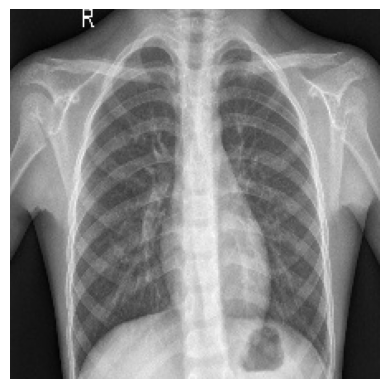

In [4]:
plt.imshow(im, cmap="gray")
plt.axis('off')
plt.show()

In [5]:
def extract_first_order_stats(image):
    return [
        np.mean(image),
        np.median(image),
        np.std(image),
        -np.sum(image * np.log2(image + 1e-10)),
        np.sum(image**2)
    ]

mean, median, std, entropy, energy = extract_first_order_stats(im)
print(
    f"Mean: {mean}, "
    f"Median: {median}, "
    f"Std: {std}, "
    f"Enrtropy: {entropy}, "
    f"Energy: {energy}"
)

Mean: 130.94981664540816, Median: 132.0, Std: 56.96156083214796, Enrtropy: -47246945.58455174, Energy: 5463010


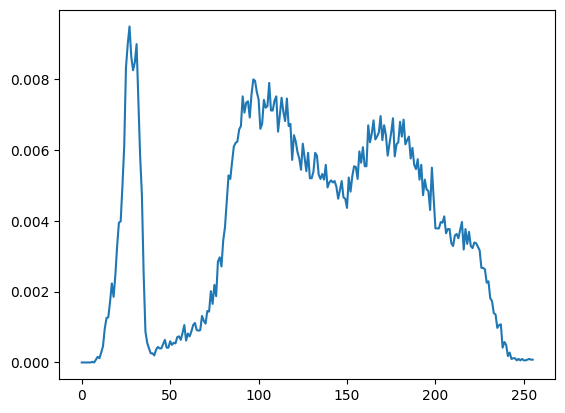

In [6]:
hist = cv.calcHist([im], [0], None, [256], [0, 256])
sum_hist = np.sum(hist)
normalized_hist = hist.flatten(
) / sum_hist if sum_hist > 0 else np.zeros(256)

plt.plot(normalized_hist)
plt.show()

hist_means = [
    np.mean(normalized_hist[i: i+50]) for i in range(0, 250, 50)
]
hist_stds = [
    np.std(normalized_hist[i: i+50]) for i in range(0, 250, 50)
]

def hist_stats(im):
    hist = cv.calcHist([im], [0], None, [256], [0, 256])
    sum_hist = np.sum(hist)
    normalized_hist = hist.flatten(
    ) / sum_hist if sum_hist > 0 else np.zeros(256)

    hist_means = [
        np.mean(normalized_hist[i: i+50]) for i in range(0, 250, 50)
    ]
    hist_stds = [
        np.std(normalized_hist[i: i+50]) for i in range(0, 250, 50)
    ]

    return hist_means, hist_stds

In [7]:
print("Means of histogram segments:", hist_means)
print("Standard deviations of histogram segments:", hist_stds)

Means of histogram segments: [np.float32(0.002459742), np.float32(0.003279257), np.float32(0.0060495054), np.float32(0.0058442284), np.float32(0.0023580997)]
Standard deviations of histogram segments: [np.float32(0.0030996779), np.float32(0.002695707), np.float32(0.0009460378), np.float32(0.0006871095), np.float32(0.0014486981)]


In [8]:
def otsu_intraclass_variance(image, threshold):
    return np.nansum(
        [
            np.mean(cls) * np.var(image, where=cls)
            for cls in [image >= threshold, image < threshold]
        ]
    )

otsus_threshold = otsu_intraclass_variance(im, 128)
print("Otsu's threshold:", otsus_threshold)

Otsu's threshold: 1016.4935776347447


In [9]:
def count_edges(im, thr1=50, thr2=150):
    img = im.copy()
    img = cv.GaussianBlur(img, (7, 7), 0)
    edges = cv.Canny(img, thr1, thr2)
    return edges, np.sum(edges > 0)


edges, edges_count = count_edges(im)
print(f"Number of edges: {edges_count}")

Number of edges: 1839


In [10]:
def count_horizontals_verticals(edges, hor_thr, ver_thr, line_thr=1):
    hor, ver = 0, 0
    im = edges.copy()
    lines = cv.HoughLines(im, 1, np.pi/180, line_thr)
    if lines is not None:
        for line in lines:
            for _, theta in line:
                angle = theta * 180 / np.pi

                if (
                    90 - hor_thr < angle < 90 + hor_thr
                ) or (
                    270 - hor_thr < angle < 270 + hor_thr
                ):
                    hor += 1

                if (
                    0 - ver_thr < angle < 0 + ver_thr
                ) or (
                    180 - ver_thr < angle < 180 + ver_thr
                ):
                    ver += 1

    return hor, ver

hor, ver = count_horizontals_verticals(edges, 1, 1)
print(f"Horizontals: {hor}, Verticals: {ver}")

Horizontals: 67, Verticals: 43


In [11]:
def extract_hog_features(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                  cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    return features.shape[0]

hog_features = extract_hog_features(im)
print(f"HOG features shape: {hog_features}")

HOG features shape: 23328


In [12]:
def extract_fft_features(image):
    fft = np.fft.fft2(image)
    magnitude = np.abs(fft)
    return [
        np.mean(magnitude),
        np.std(magnitude)
    ]

fft_mean, fft_std = extract_fft_features(im)
print(f"FFT mean: {fft_mean}, FFT std: {fft_std}")

FFT mean: 2793.6614744865765, FFT std: 31865.470741320758


In [13]:
def fractal_dimension(image, threshold=128):
    def boxcount(image, k):
        # Non-overlapping blocks of size k x k
        S = np.add.reduceat(
            np.add.reduceat(image, 
                           np.arange(0, image.shape[0], k), 
                           axis=0),
            np.arange(0, image.shape[1], k), 
            axis=1)
        return len(np.where(S > 0)[0])
    
    binary = (image > threshold).astype(int)
    sizes = 2**np.arange(1, 8)
    counts = [boxcount(binary, size) for size in sizes]
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

fractal_dim = fractal_dimension(im)
print(f"Fractal Dimension: {fractal_dim:.4f}")

Fractal Dimension: 1.7804


In [14]:
def extract_hu_moments(image):
    moments = cv.moments(image)
    hu_moments = cv.HuMoments(moments).flatten()
    return list(hu_moments)

hu_moments = extract_hu_moments(im)
print("Hu Moments:", hu_moments)

Hu Moments: [np.float64(0.001119922572828036), np.float64(5.041633582003237e-09), np.float64(3.0155656147457464e-11), np.float64(6.839145937296847e-13), np.float64(3.1037261105229333e-24), np.float64(-1.488110363486339e-17), np.float64(1.1613357430228318e-25)]


In [15]:
def extract_features(im):
    # General stats
    mean, median, std, entropy, energy = extract_first_order_stats(im)

    # Histogram stats
    hist_means, hist_stds = hist_stats(im)

    # Otsu's threshold
    otsus_threshold = otsu_intraclass_variance(im, 128)

    # Number of edges
    edges, edges_count = count_edges(im)

    # Horizontal and vertical lines
    hor, ver = count_horizontals_verticals(edges, 1, 1)

    # HOG features
    hog_features = extract_hog_features(im)

    # FFT mean and std
    fft_mean, fft_std = extract_fft_features(im)

    # Fractal dim
    fractal_dim = fractal_dimension(im)

    # Hu's seven invariant moments
    hu_moments = extract_hu_moments(im)

    return np.array([
        mean, median, std, entropy, energy,

        hist_means[0], hist_means[1], hist_means[2], hist_means[3], hist_means[4],
        hist_stds[0], hist_stds[1], hist_stds[2], hist_stds[3], hist_stds[4],

        otsus_threshold,

        edges_count,

        hor, ver,

        hog_features,

        fft_mean, fft_std,

        fractal_dim,

        hu_moments[0], hu_moments[1], hu_moments[2], hu_moments[3],
        hu_moments[4], hu_moments[5], hu_moments[6]
    ])


feature_names = [
    "mean", "median", "std", "entropy", "energy",
    
    "hist_means_0_50", "hist_means_51_100", "hist_means_101, 150",
    "hist_means_151_200", "hist_means_201_250",
    "hist_std_0_50", "hist_std_51_100", "hist_std_101_150",
    "hist_std_151_200", "hist_std_201_250",

    "otsu_threshold",

    "n_edges",
    
    "horizontal_lines", "vertical_lines",

    "hog_features",

    "fft_mean", "fft_std",

    "fractal_dim",

    "hu_moment_1", "hu_moment_2", "hu_moment_3", "hu_moment_4", "hu_moment_5",
    "hu_moment_6", "hu_moment_7"
]


In [16]:
features = extract_features(im)
for fname, f in zip(feature_names, features):
    print(fname + ":", f)

mean: 130.94981664540816
median: 132.0
std: 56.96156083214796
entropy: -47246945.58455174
energy: 5463010.0
hist_means_0_50: 0.002459741896018386
hist_means_51_100: 0.0032792571000754833
hist_means_101, 150: 0.0060495054349303246
hist_means_151_200: 0.005844228435307741
hist_means_201_250: 0.002358099678531289
hist_std_0_50: 0.003099677851423621
hist_std_51_100: 0.002695706905797124
hist_std_101_150: 0.0009460378205403686
hist_std_151_200: 0.0006871094810776412
hist_std_201_250: 0.0014486981090158224
otsu_threshold: 1016.4935776347447
n_edges: 1839.0
horizontal_lines: 67.0
vertical_lines: 43.0
hog_features: 23328.0
fft_mean: 2793.6614744865765
fft_std: 31865.470741320758
fractal_dim: 1.7803597181223167
hu_moment_1: 0.001119922572828036
hu_moment_2: 5.041633582003237e-09
hu_moment_3: 3.0155656147457464e-11
hu_moment_4: 6.839145937296847e-13
hu_moment_5: 3.1037261105229333e-24
hu_moment_6: -1.488110363486339e-17
hu_moment_7: 1.1613357430228318e-25


In [17]:
from src.classical_ml import FeatureExtractor

In [18]:
otsu_thr = 128
edge_thr1 = 50
edge_thr2 = 150
line_thr = 1
hor_thr = 1
ver_thr = 1
hog_orientations = 8
hog_pixels_per_cell = (8, 8)
hog_cells_per_block = (2, 2)
frac_thr = 128

extractor = FeatureExtractor(
    img=im,
    otsu_thr=otsu_thr,
    edge_thr1=edge_thr1,
    edge_thr2=edge_thr2,
    line_thr=line_thr,
    hor_thr=hor_thr,
    ver_thr=ver_thr,
    hog_orientations=hog_orientations,
    hog_pixels_per_cell=hog_pixels_per_cell,
    hog_cells_per_block=hog_cells_per_block,
    frac_thr=frac_thr
)
fnames = extractor.FEATURE_NAMES
fs = extractor.extract_features()

for fname, f in zip(fnames, fs):
    print(fname + ":", f)

mean: 130.94981664540816
median: 132.0
std: 56.96156083214796
entropy: -47246945.58455174
energy: 5463010.0
hist_means_0_50: 0.002459741896018386
hist_means_51_100: 0.0032792571000754833
hist_means_101, 150: 0.0060495054349303246
hist_means_151_200: 0.005844228435307741
hist_means_201_250: 0.002358099678531289
hist_std_0_50: 0.003099677851423621
hist_std_51_100: 0.002695706905797124
hist_std_101_150: 0.0009460378205403686
hist_std_151_200: 0.0006871094810776412
hist_std_201_250: 0.0014486981090158224
otsu_threshold: 1016.4935776347447
n_edges: 1839.0
horizontal_lines: 67.0
vertical_lines: 43.0
hog_features: 23328.0
fft_mean: 2793.6614744865765
fft_std: 31865.470741320758
fractal_dim: 1.7803597181223167
hu_moment_1: 0.001119922572828036
hu_moment_2: 5.041633582003237e-09
hu_moment_3: 3.0155656147457464e-11
hu_moment_4: 6.839145937296847e-13
hu_moment_5: 3.1037261105229333e-24
hu_moment_6: -1.488110363486339e-17
hu_moment_7: 1.1613357430228318e-25
